<a href="https://colab.research.google.com/github/k2moon/ml-hg/blob/main/hg_09_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM과 GRU 셀
---

## 핵심 키워드
---
- LSTM
- 셀상태
- GRU

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/9-3.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [ ]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## LSTM Long Short-Term Memory
---
- 입력과 가중치를 곱하고 절편을 더해 활성화 함수를 통과시키는 구조가 여러개 임
- 이 계산 결과는 다음 타임스텝에서 재사용
- 기본 RNN은 시퀜스가 길수록 순환되는 은닉 상태 정보가 점차 희석되어 희미 해짐 

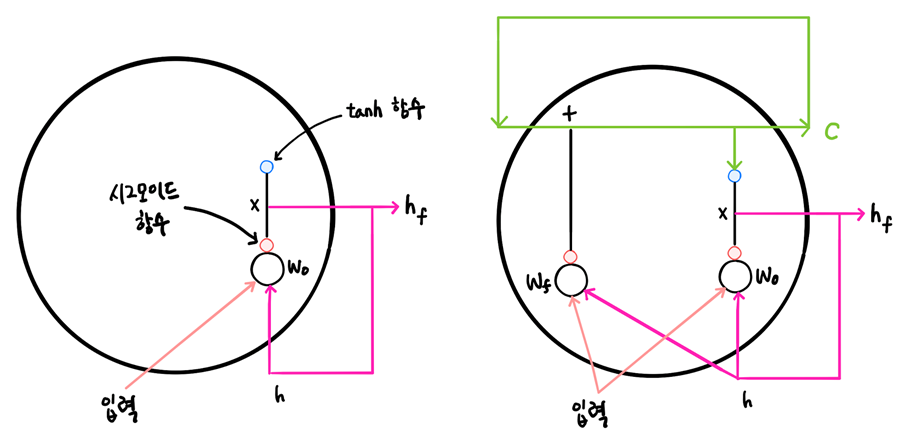

 ### 은닉상태와 셀 상태 cell state I
 ---
 - LSTM에는 순환되는 상태가 2개
 - 은닉 상태는 입력과 이전 타입스텝의 은닉 상태를 가중치에 곱한 후 활성화 함수 시그모이드를 통과시켜 다음 은닉 상태를 만듬
 - 또 tanh 활성화 함수를 통과한 어떤 값과 곱해져서 은닉 상태를 만듬
 - tanh 활성화 함수를 통과한 어떤 값이 이 셀 상태의 값으로 다음 층으로 전달 되지 않고 LSTM 셀에서 순환만 되는 값
 - 셀 상태는 입력과 은닉 상태를 또 다른 가중치 $W_f$에 곱한 다음 시그모이드 함수를 통시켜 계산 후 이전 타임스텝의 셀 상태와 곱하여 새로운 셀 상태 만들어 지고 이 값으 tanh 함수를 통과하여 새로운 은닉 상태에게 기여함
 - LMTM은 작은 셀을 여러 개 포함하는 큰 셀로 작동
 - 중요한 것은 입력과 은닉 상태에 곱해지는 가중치 $W_f$, $W_0$이 다르다는 점
   

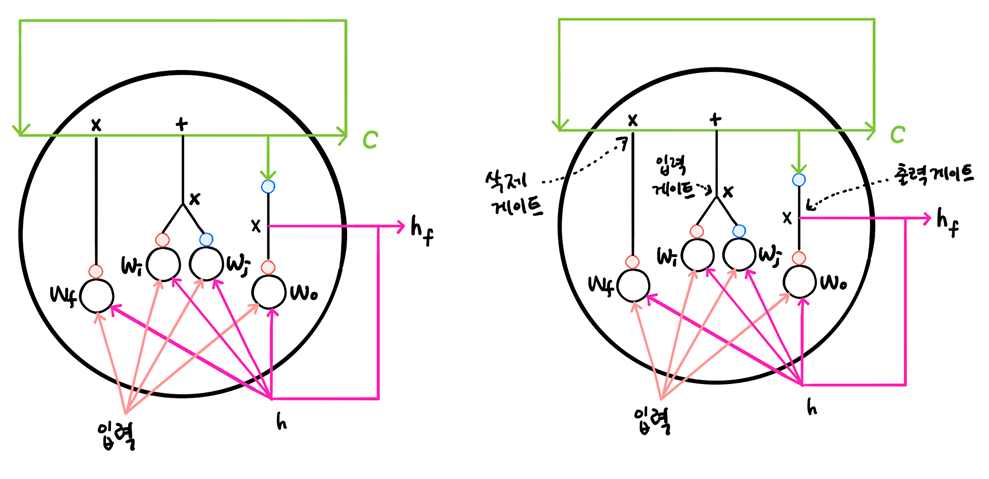

### 은닉상태와 셀 상태 cell state II
---
- LSTM 2개의 셀이 더 추가되어 4개의 셀을 가짐
- 은닉 상태는 입력과 이전 타입스텝의 은닉 상태를 가중치에 곱한 후 활성화 함수 시그모이드와 tanh를 각각 통과시킨 후 곱한 후 이전 셀 상태 값과 더함
- 이게 최종 셀 상태의 값이며 tanh를 통과시켜 보냄
- 세군데의 곱샘 부분을 삭제 게이트, 입력 게이트, 출력 게이트라고 함

## LSTM 신경망 훈련하기

In [1]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

17464789/17464789 [==============================] - 2s 0us/step


- IMDB 리뷰 데이터 로드하고 훈련 세트와 검증 세트로 나누기
- 샘플의 길이를 100에 맞추고 부족할 때는 패딩 추가

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

- SimpleRNN 대신 LSTM 클래스 생성
- LSTM은 작은 셀이 4개 더 있어 200 * 4 =  800개 파라미터

In [4]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


- 배치 크기 64, 에포크 100회, 체크 포인트와 조기 종료 적용

In [4]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', 
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 14s 39ms/step - loss: 0.6921 - accuracy: 0.5570 - val_loss: 0.6909 - val_accuracy: 0.5824
Epoch 2/100
313/313 [==============================] - 14s 44ms/step - loss: 0.6882 - accuracy: 0.6282 - val_loss: 0.6852 - val_accuracy: 0.6340
Epoch 3/100
313/313 [==============================] - 12s 39ms/step - loss: 0.6768 - accuracy: 0.6660 - val_loss: 0.6653 - val_accuracy: 0.6850
Epoch 4/100
313/313 [==============================] - 12s 37ms/step - loss: 0.6168 - accuracy: 0.7145 - val_loss: 0.5631 - val_accuracy: 0.7288
Epoch 5/100
313/313 [==============================] - 12s 37ms/step - loss: 0.5425 - accuracy: 0.7411 - val_loss: 0.5332 - val_accuracy: 0.7452
Epoch 6/100
313/313 [==============================] - 12s 37ms/step - loss: 0.5158 - accuracy: 0.7611 - val_loss: 0.5107 - val_accuracy: 0.7590
Epoch 7/100
313/313 [==============================] - 12s 37ms/step - loss: 0.4952 - accuracy: 0.7741 - val_loss: 0.4951 - val_ac

- 훈련 손실과 검증 손실 그래프

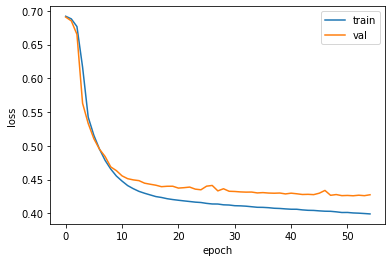

In [5]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

> **LSTM이 과적합을 억제하면서 훈련이 잘 수행된 것으로 보임**

## 순환 층에 드롭아웃 적용하기
---
- RNN층은 자체적으로 과대적합을 규제할 드롭아웃 기능 제공
- dropout 파라미터는 셀 입력 , recurrent_dropout은 순환되는 은닉상태에 드럽아웃 적용, 0.3은 30%
- recurrent_dropout 적용시 GPU 사용이 불가함

In [5]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [6]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 10s 11ms/step - loss: 0.6929 - accuracy: 0.5148 - val_loss: 0.6925 - val_accuracy: 0.5418
Epoch 2/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6915 - accuracy: 0.5770 - val_loss: 0.6908 - val_accuracy: 0.6060
Epoch 3/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6888 - accuracy: 0.6227 - val_loss: 0.6871 - val_accuracy: 0.6292
Epoch 4/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6822 - accuracy: 0.6386 - val_loss: 0.6767 - val_accuracy: 0.6592
Epoch 5/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6521 - accuracy: 0.6399 - val_loss: 0.6259 - val_accuracy: 0.6802
Epoch 6/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6022 - accuracy: 0.7150 - val_loss: 0.5928 - val_accuracy: 0.7374
Epoch 7/100
313/313 [==============================] - 3s 9ms/step - loss: 0.5783 - accuracy: 0.7434 - val_loss: 0.5752 - val_accuracy: 0.75

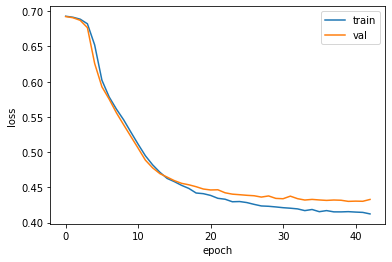

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

> **훈련 손실과 검증 손실 간의 차이가 좁혀진 것이 확인 됨**

## 2개의 순환층을 연결하기
---
- 주의 할점은 기본 RNN 처럼 마지막 타임스텝의 은닉상태가 아니라면 return_squences=True 지정해서 모든 타임스텝의 은닉 상태를 출력으로 전달 해야함
- lstm_2 (LSTM) (None, 100, 8) 100개의 은닉상태 포함 모든 상태 출력
- lstm_3 (LSTM) (None, 8) 마지막 만 출력

In [9]:
model3 = keras.Sequential()

model3.add(keras.layers.Embedding(500, 16, input_length=100))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_2 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_3 (LSTM)               (None, 8)                 544       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


In [10]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model3.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 8s 16ms/step - loss: 0.6927 - accuracy: 0.5311 - val_loss: 0.6923 - val_accuracy: 0.5100
Epoch 2/100
313/313 [==============================] - 4s 14ms/step - loss: 0.6896 - accuracy: 0.6068 - val_loss: 0.6857 - val_accuracy: 0.5662
Epoch 3/100
313/313 [==============================] - 5s 15ms/step - loss: 0.6567 - accuracy: 0.6671 - val_loss: 0.6160 - val_accuracy: 0.6978
Epoch 4/100
313/313 [==============================] - 5s 15ms/step - loss: 0.5983 - accuracy: 0.7033 - val_loss: 0.5828 - val_accuracy: 0.7172
Epoch 5/100
313/313 [==============================] - 4s 14ms/step - loss: 0.5682 - accuracy: 0.7297 - val_loss: 0.5563 - val_accuracy: 0.7382
Epoch 6/100
313/313 [==============================] - 5s 15ms/step - loss: 0.5496 - accuracy: 0.7418 - val_loss: 0.5364 - val_accuracy: 0.7512
Epoch 7/100
313/313 [==============================] - 5s 17ms/step - loss: 0.5332 - accuracy: 0.7502 - val_loss: 0.5256 - val_accuracy:

> **일반적으로는 RNN층을 쌓으면 성능이 높아짐**

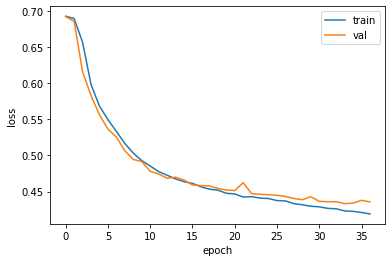

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

> **과대적합을 제어하면서 손실을 최대한 낮춘 모습이 그려짐**

## GRU Gated Recurrent Unit 구조
---
- 뉴욕대 조경현 교수가 발명한 셀로 유명
- LSTM의 간소화 버전으로 셀 상태를 계산하지 않고 은닉 상태 하나만 포함하는 대신 작은 셀을 3개 포함 
- LSTM보다 가중치가 적기 때문에 계산량이 적지만 좋은 성능을 내는 것으로 알려져 있음
- 실제 텐서플로에서는 GPU의 사용을 위해 오른쪽 그림으로 구현 되어서 사용됨, 이론과 구현의 차이

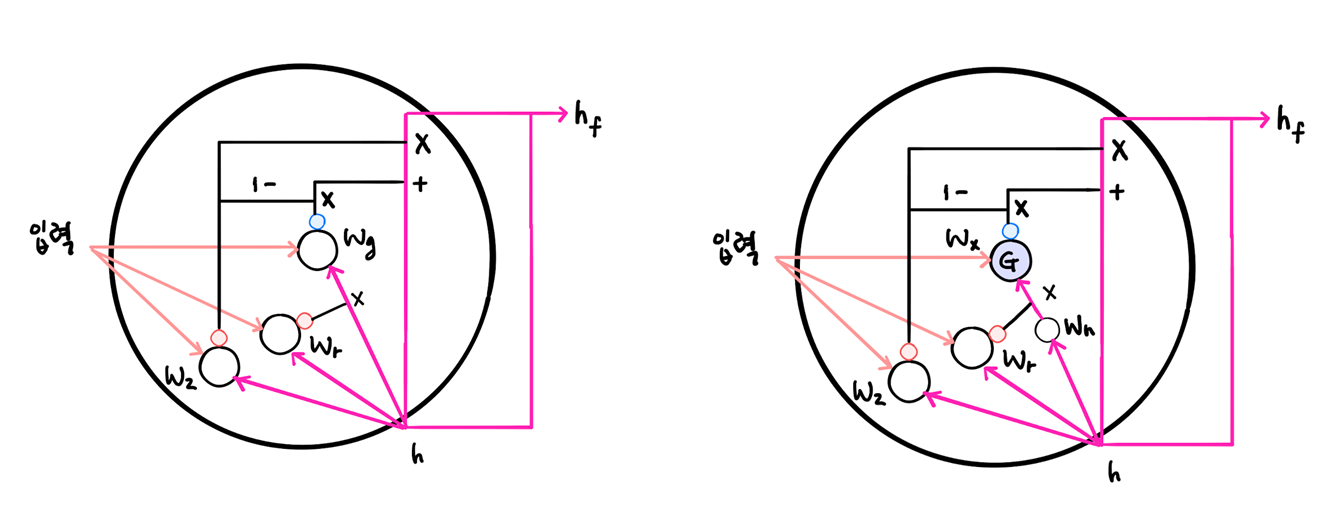

- 은닉 상태는 입력과 이전 타입스텝의 은닉 상태를 가중치에 곱하고 절편을 더하는 작은 셀 3개가 있음
- 2개는 시그모이드 함수를 사용하고 1개는 tanh 함수를 사용
- $W_z$를 사용하는 셀이 은닉 상태의 값이 바로 곱해저 삭제 게이트 역할을 하고 1에서 값을 뺀 후 $W_g$를 사용하는 출력과 곱해짐으로 입력 되는 정보 제어 역할
- $W_r$ 셀 출력값은 $W_g$이 사용할 은닉 정보 제어 역할

## GRU 신경망 훈련하기
---
- GRU 클래스 사용
- output 계산 : 600 = (16 * 8(입력 가중치) + 8 * 8 (은닉 가중치) + 8 (절편) ) * 3(작은셀)
- 실제는 텐서플로의 구현 방법으로 바뀌면서 24개 더 추가됨 624개

In [12]:
model4 = keras.Sequential()

model4.add(keras.layers.Embedding(500, 16, input_length=100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


In [13]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model4.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 5s 10ms/step - loss: 0.6920 - accuracy: 0.5354 - val_loss: 0.6910 - val_accuracy: 0.5504
Epoch 2/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6889 - accuracy: 0.5717 - val_loss: 0.6873 - val_accuracy: 0.5744
Epoch 3/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6834 - accuracy: 0.6037 - val_loss: 0.6803 - val_accuracy: 0.6072
Epoch 4/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6731 - accuracy: 0.6281 - val_loss: 0.6677 - val_accuracy: 0.6268
Epoch 5/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6548 - accuracy: 0.6521 - val_loss: 0.6446 - val_accuracy: 0.6588
Epoch 6/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6173 - accuracy: 0.6830 - val_loss: 0.5916 - val_accuracy: 0.7046
Epoch 7/100
313/313 [==============================] - 3s 9ms/step - loss: 0.5450 - accuracy: 0.7298 - val_loss: 0.5278 - val_accuracy: 0.745

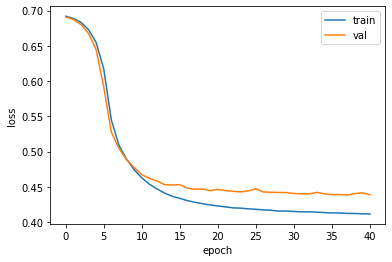

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

> **드롭아웃 등을 사용하지 않아 손실 사이의 차이가 있지만 훈련 과정이 잘 수렴되었으며 LSTM과 거으 비슷한 성능을 보임** 

## 최적의 모델로 성능 평가
---


In [15]:
test_seq = pad_sequences(test_input, maxlen=100)

rnn_model = keras.models.load_model('best-2rnn-model.h5')

rnn_model.evaluate(test_seq, test_target)

782/782 [==============================] - 5s 6ms/step - loss: 0.4311 - accuracy: 0.7986


[0.43107300996780396, 0.7986400127410889]

## 더 배울 것들
---
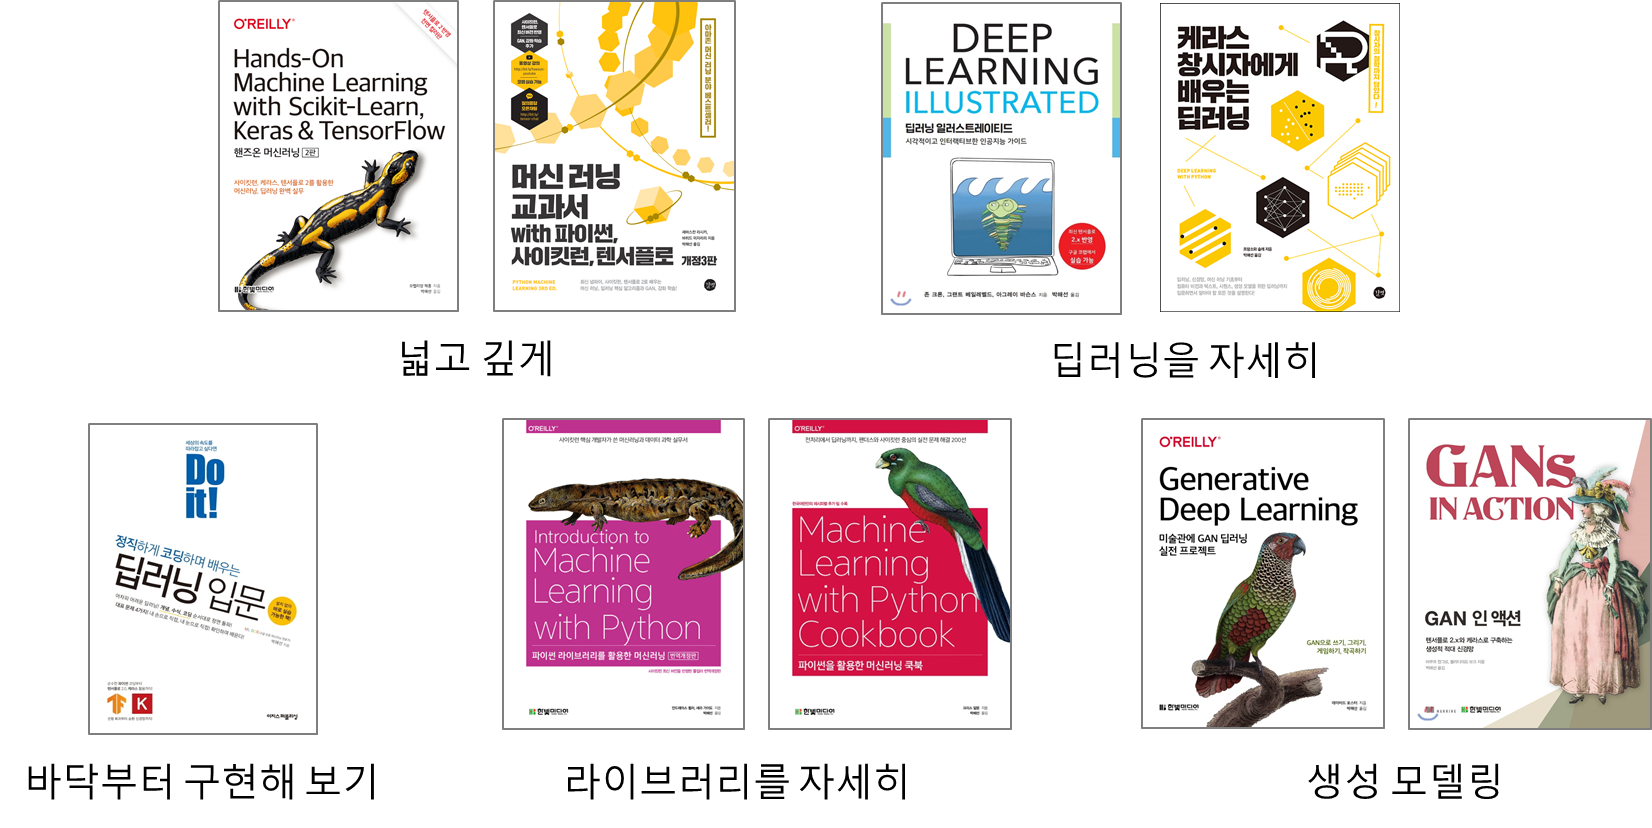